In [78]:
from __future__ import print_function
import re
import pandas as pd
import numpy as np
from os import listdir
from collections import Counter
from bs4 import BeautifulSoup
import sklearn
import xgboost as xgb
import nltk
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


import math 
import gensim

import pickle

from string import punctuation
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

#### Get Texts

In [8]:
doc_path = r'C:\Users\Artur_Zahreba\Desktop\WorkFusion\P&G\Approval By Email\Training Set\v5\Training Set\ALL_FIXED'

In [9]:
doc_types = sorted(listdir(doc_path))

doc_texts = []

for doc_type in doc_types:
    filenames = sorted(listdir(doc_path + '\\' + doc_type))
    filenames = filter(lambda x: re.search(r'\.txt$', x), filenames)
    for filename in filenames:
        with open(doc_path + '\\' + doc_type + '\\' + filename, 'r') as ffile:
            txt = ffile.read()
            doc_texts.append((doc_type, filename, txt))
            ffile.close()
            
print(len(doc_texts))

737


In [10]:
lables, _, texts = zip(*doc_texts)

# Tokenize Text

https://app.pluralsight.com/player?course=python-natural-language-processing

## Word Tokenize Default

In [11]:
from nltk.tokenize import word_tokenize

In [12]:
from nltk.corpus import stopwords
from string import punctuation

In [13]:
_stopwords = set(stopwords.words('english') 
                 + list(punctuation)
                 + ["pg.com"]
                )

In [14]:
# def tokenize_text(text):
#     return [w for w in word_tokenize(text) if w not in _stopwords]

def tokenize_text(text):
    stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
    # tokenizer = RegexpTokenizer(r'[a-z\d]{2,}')
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    
#     text = re.sub(r'\s\d+\s', ' ', ' '.join(text))
    text = stemmer.stem(text)
    words = tokenizer.tokenize(text)
    return words
    
# def tokenize_text(text):
#     stemmer = LancasterStemmer()
#     tokenizer = RegexpTokenizer(r'\s+', gaps=True)

#     words = tokenizer.tokenize(text)
#     words = [stemmer.stem(word) for word in words]
#     return words

# Identify Bigrams

In [15]:
from nltk.collocations import *

In [16]:
all_text = ''
for t in texts:
    all_text += ' ' + t
    
words = tokenize_text(all_text)
words[0]

u'from:'

In [17]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)
bigrams = sorted(finder.ngram_fd.items(), key = lambda x: x[1], reverse = True)
print('Max: ' + str(bigrams[0][1]))
[b for b in bigrams if ('pprove' in b[0][0]) or ('pprove' in b[0][1])]

Max: 2963


[((u'please', u'approve'), 330),
 ((u'approve', u'attached'), 200),
 ((u'approve', u'anna'), 180),
 ((u'approved.', u'best'), 93),
 ((u'approve', u'the'), 50),
 ((u'request', u'approve'), 40),
 ((u'2017', u'approved.'), 39),
 ((u'nro', u'approve'), 37),
 ((u'to', u'approve'), 30),
 ((u'approved', u'from:'), 30),
 ((u'approve', u'on'), 30),
 ((u'sale', u'approved.'), 26),
 ((u'approve', u'for'), 26),
 ((u'approve', u'nro'), 19),
 ((u'be', u're-approve'), 19),
 ((u're-approve', u'and'), 19),
 ((u'approved.', u'thank'), 18),
 ((u'anna', u'approve.'), 18),
 ((u'approve.', u'warm'), 18),
 ((u'approve', u'as'), 18),
 ((u'approved', u'for'), 17),
 ((u'approved.', u'thanks!'), 16),
 ((u'event', u'approved'), 16),
 ((u'has', u'approved'), 15),
 ((u'kindly', u'approve'), 15),
 ((u'contest.xlsx', u'approve'), 14),
 ((u'approve', u'again.'), 14),
 ((u'jas', u'approved.'), 14),
 ((u'2002450853', u'approver:'), 13),
 ((u'and', u'approve'), 13),
 ((u'approved.', u'thanks.'), 12),
 ((u'approved', u'an

In [18]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(words)
sorted(finder.ngram_fd.items(), key =lambda x: x[1], reverse = True)[:100]

[((u'you', u'are', u'not'), 1603),
 ((u'if', u'you', u'are'), 1596),
 ((u'in', u'error,', u'please'), 1540),
 ((u'use', u'of', u'the'), 1511),
 ((u'are', u'not', u'the'), 1506),
 ((u'have', u'received', u'this'), 1501),
 ((u'error,', u'please', u'notify'), 1494),
 ((u'the', u'use', u'of'), 1486),
 ((u'for', u'the', u'use'), 1486),
 ((u'not', u'the', u'intended'), 1466),
 ((u'the', u'intended', u'recipient,'), 1461),
 ((u'of', u'the', u'individual'), 1431),
 ((u'the', u'individual', u'or'), 1431),
 ((u'individual', u'or', u'entity'), 1431),
 ((u'intended', u'for', u'the'), 1421),
 ((u'which', u'may', u'be'), 1419),
 ((u'or', u'entity', u'named'), 1413),
 ((u'the', u'information', u'is'), 1408),
 ((u'is', u'intended', u'for'), 1405),
 ((u'entity', u'named', u'above.'), 1402),
 ((u'confidential.', u'the', u'information'), 1402),
 ((u'this', u'electronic', u'transmission'), 1402),
 ((u'above.', u'if', u'you'), 1402),
 ((u'information', u'is', u'intended'), 1402),
 ((u'electronic', u'messag

# POS tagging

In [ ]:
nltk.pos_tag(words)

# AutoSummarize Emails

In [19]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [20]:
texts = [sent_tokenize(t) for t in texts]

In [21]:
all_words = words

In [22]:
from nltk.probability import FreqDist
freq = FreqDist(all_words)
freq

FreqDist({u'1,800': 12,
          u'sgd13,000)': 1,
          u'yellow': 29,
          u'del.': 11,
          u'four': 4,
          u'16572518': 1,
          u'prefix': 2,
          u'sk-iis': 3,
          u'travelretail,ion': 1,
          u'looking': 43,
          u'16563759': 1,
          u'ooo:': 812,
          u'adviced.': 2,
          u'thus,': 8,
          u'-kevin': 21,
          u'5981': 2,
          u'82435404': 1,
          u'shipment).': 9,
          u'82248642': 56,
          u'update.': 8,
          u'131595': 6,
          u'82248641': 2,
          u'82248646': 102,
          u'(noey).': 9,
          u'82248644': 13,
          u'82248649': 80,
          u',and': 6,
          u'241672': 3,
          u'29.05.2017': 8,
          u'45.9': 2,
          u'08:00:07': 1,
          u'darryl!': 1,
          u'darryl"': 5,
          u'chansaengsri': 13,
          u'darryl,': 121,
          u'regional': 14,
          u'advice.': 74,
          u'45.5': 1,
          u'advice,': 5,
     

In [23]:
from heapq import nlargest
print(nlargest(100, freq, key = freq.get))

[u'the', u'for', u'to', u'please', u'and', u'this', u'of', u'-', u'from:', u'sent:', u'you', u'to:', u'subject:', u'2017', u'may', u'>;', u'cc:', u'is', u'are', u'on', u're:', u'intended', u'hi', u'in', u':', u'information', u'transmission', u'electronic', u'onetravelretail,', u'tan,', u'be', u'regards,', u'have', u'if', u'nro', u'sk-ii', u'not', u'ion', u'>', u'pm', u'liang,', u'order', u'ok', u'best', u'or', u'thank', u'anna', u'darryl', u'&', u'dear', u'use', u'message', u'received', u'sk2', u'lu,', u'eunice,', u'sender', u'your', u'at', u'notify', u'nino,', u'singapore', u'delete', u'we', u'which', u'facial', u'ian', u'recipient,', u'all', u'error,', u'treatment', u'herwen', u'muthuraman,', u'essence', u'alagammai', u'|', u'chiam', u'then', u'entity', u'named', u'immediately.', u'individual', u'above.', u'daisyanne', u'confidential.', u'contains', u'with', u'new', u'will', u'april', u'sg', u'skii', u'sa', u'as', u'am', u'thanks', u'i', u'dfs', u'branch', u'p&g']


In [24]:
# Compute significance score for each sentance
from collections import defaultdict
ranking = defaultdict(int)

def getRanking(sents):
    for i, sent in enumerate(sents):
        for w in tokenize_text(sent.lower()):
            if w in freq:
                ranking[i] += freq[w]
            
    return ranking

In [25]:
rankings = [getRanking(sents) for sents in texts]
rankings_5 = [sorted(nlargest(1, ranking, key=ranking.get)) for ranking in rankings]

In [26]:
summarized_texts = []

for txt_idx, sents in enumerate(texts):
    sents = [sent for ind, sent in enumerate(sents) if ind in rankings_5[txt_idx]]
    summarized_texts.append(sents)
    
print(summarized_texts[0])
print()
print(summarized_texts[1])
print()
print(summarized_texts[2])
print()
print(summarized_texts[3])

['From: Liang, Anna\nSent: Wed May 17 10:05:28 CEST 2017\nTo: Chia, Ian; Nino, DaisyAnne; onetravelretail, Ion; Muthuraman, Alagammai\nCc: Tan, HerWen; Neo, Joyce; Eunice, Chiam\nSubject: : [Approval] NRO - Kingpower Tester request\nApprove\n\nAnna \n\n \n\n: Chia, Ian \n: 2017517 16:00\n: Nino, DaisyAnne <nino.d@pg.com>; onetravelretail, Ion\n<onetravelretail.im@pg.com>; Muthuraman, Alagammai\n<muthuraman.am@pg.com>\n: Tan, HerWen <tan.hw@pg.com>; Neo, Joyce <neo.j.1@pg.com>; Liang,\nAnna <liang.an.2@pg.com>; Eunice, Chiam <eunice.ec@pg.com>\n: RE: [Approval] NRO - Kingpower Tester request\n\n \n\nHi Anna,\n\n \n\nPlease approve attached NRO.']

['From: Liang, Anna\nSent: Thu Apr 20 14:48:36 CEST 2017\nTo: Eunice, Chiam; Muthuraman, Alagammai; Lu, Darryl; onetravelretail, Ion; Lim, ChunTong; Nino, DaisyAnne\nCc: Chai, Winnie; Liang, Ginny\nSubject: : [Approval] TW KOL giveaway\nApprove\n\nAnna \n\n \n\n: Eunice, Chiam \n: 2017420 15:37\n: Muthuraman, Alagammai <muthuraman.am@pg.com>; 

In [27]:
def summarize(text, n):
    sents = sent_tokenize(text)
    
    assert n <= len(sents)
    word_sent = word_tokenize(text.lower())
    _stopwords = set(stopwords.words('english') + list(punctuation))
    
    word_sent = [word for word in word_sent if word not in _stopwords]
    freq = FreqDist(word_sent)
    
    ranking = defaultdict(int)
    
    for i,sent in enumerate(sents):
        for w in word_tokenize(sent.lower()):
            if w in freq:
                ranking[i] += freq[w]
             
        
    sents_idx = nlargest(n, ranking, key=ranking.get)
    return [sents[j] for j in sorted(sents_idx)]

# Clusterize with KMeans

In [28]:
# each document is a tuple of N numbers
# N - total number of distinct words in ALL documents

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df = 0.9,
    min_df = 0.3,
    stop_words = 'english'
)
vectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.3,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [29]:
from sklearn.cluster import KMeans

number_of_classes = 2

km = KMeans(
    n_clusters = number_of_classes,
    init = 'k-means++', # method of choosing initial centroids
    max_iter = 1000, 
    n_init = 1, 
    verbose = True
)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [47]:
# rows = number of texts
# cols = number of distinct words in all texts

labels, _, texts = zip(*doc_texts)

X = vectorizer.fit_transform(texts)
X

<737x128 sparse matrix of type '<type 'numpy.float64'>'
	with 45891 stored elements in Compressed Sparse Row format>

In [32]:
km.fit(X)

Initialization complete
Iteration  0, inertia 893.568
Iteration  1, inertia 424.774
Iteration  2, inertia 417.654
Iteration  3, inertia 415.926
Iteration  4, inertia 415.740
Iteration  5, inertia 415.725
Converged at iteration 5: center shift 0.000000e+00 within tolerance 5.027084e-07


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [33]:
import numpy as np
np.unique(km.labels_, return_counts=True)

(array([0, 1]), array([317, 420], dtype=int64))

In [35]:
text = {}
for i, cluster in enumerate(km.labels_):
    oneDocument = doc_texts[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument
# km.labels_

In [36]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from heapq import nlargest


keywords = {}
counts = {}

for cluster in range(number_of_classes):
    word_sent = tokenize_text(texts[cluster])
#     word_sent = [word for word in word_sent if word.lower() not in _stopwords]
    freq = FreqDist(word_sent)
    keywords[cluster] = nlargest(20, freq, key=freq.get)
    counts[cluster]=freq
keywords

{0: [u'the',
  u'>;',
  u'ok',
  u'please',
  u'may',
  u'4',
  u'tester',
  u'>',
  u'and',
  u'of',
  u'this',
  u'ian',
  u'for',
  u'transmission',
  u'information',
  u'intended',
  u'electronic',
  u'are',
  u'nro',
  u'on'],
 1: [u'liang,',
  u'the',
  u'anna',
  u'tw',
  u'kol',
  u'chai,',
  u'ginny',
  u'giveaway',
  u'chiam',
  u'lim,',
  u'eunice,',
  u'chuntong',
  u'winnie',
  u'2017',
  u'to:',
  u'sent:',
  u'from:',
  u'subject:',
  u're:',
  u'<chai.w@pg.com>;']}

In [37]:
unique_keys = {}

for cluster in range(number_of_classes):   
    other_clusters = list(set(range(number_of_classes)) - set([cluster]))
    keys_other_clusters = set(keywords[other_clusters[0]]) #.union(set(keywords[other_clusters[1]]))
    unique = set(keywords[cluster]) - keys_other_clusters
    unique_keys[cluster] = nlargest(10, unique, key=counts[cluster].get)
    
unique_keys

{0: [u'>;',
  u'ok',
  u'please',
  u'may',
  u'4',
  u'tester',
  u'>',
  u'and',
  u'of',
  u'for'],
 1: [u'liang,',
  u'anna',
  u'tw',
  u'kol',
  u'chai,',
  u'lim,',
  u'eunice,',
  u'giveaway',
  u'chiam',
  u'ginny']}

In [38]:
approval_text = "I approve on behalf of Anna"

In [39]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X, km.labels_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [40]:
test = vectorizer.transform([approval_text.encode('ascii', errors='ignore').decode('utf8')])

In [41]:
classifier.predict(test)

array([1])

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [55]:
lable_dict = dict(zip(list(set(lables)), range(len(set(lables)))))
lables_int = map(lambda x: lable_dict[x], lables)

In [60]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

X = pipeline.fit_transform(texts).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c = lables_int)

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0],
            centers2D[:,1], 
            marker='x',
            s=200,
            linewidths=3,
            c='r')

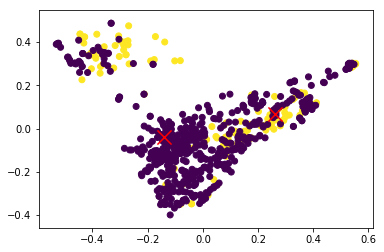

In [62]:
plt.show()              #not required if using ipython notebook

In [75]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from matplotlib.pyplot import figure, subplot, scatter

In [76]:
X = vectorizer.fit_transform(texts)

X_tsne = TSNE(learning_rate=100).fit_transform(X.toarray())
X_pca = PCA().fit_transform(X.toarray())

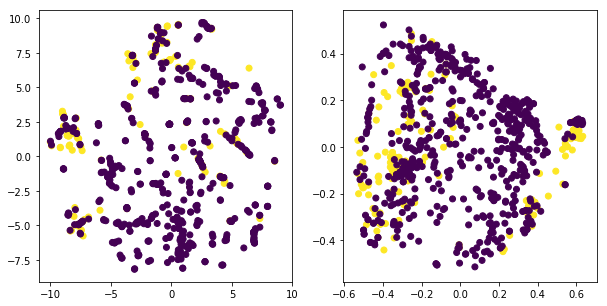

In [79]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c= lables_int)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c= lables_int)